# All experiments LTN Notebook

This notebook contains experiments on the MNIST model. It will contain the following experiments:
- changing the number of layers, learning rate etc for basic single_digits_addition and comparing results
- adding different levels of symbolic knowledge to the single_digits_addition
- multiple_digits_addition with more symbolic knowledge

In [1]:
import tensorflow as tf
import ltn
import baselines, data
import commons_updated as commons
import matplotlib.pyplot as plt

## Single Digit Addition

## Data

Dataset of images for the digits X and Y, and their label Z s.t. X+Y=Z.

Result label is 9


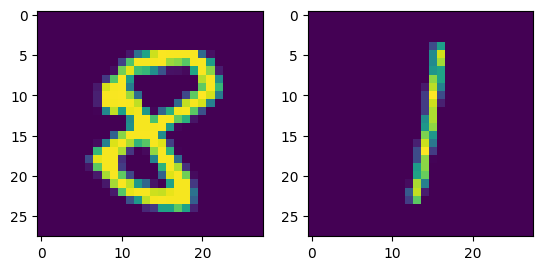

In [2]:
ds_train, ds_test = data.get_mnist_op_dataset(
        count_train=3000,
        count_test=1000,
        buffer_size=3000,
        batch_size=16,
        n_operands=2,
        op=lambda args: args[0]+args[1])

# Visualize one example
x, y, z = next(ds_train.as_numpy_iterator())
plt.subplot(121)
plt.imshow(x[0][:,:,0])
plt.subplot(122)
plt.imshow(y[0][:,:,0])
print("Result label is %i" % z[0])

## Model Definition

In [10]:
class SoftmaxDigitModel(tf.keras.Model):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model

    def call(self, x):
        logits = self.base_model(x)
        return tf.nn.softmax(logits)

def create_Digit_model(layers_sizes=(84,), batch_size=16):
    logits_model = baselines.SingleDigit(hidden_dense_sizes=layers_sizes, inputs_as_a_list=True)
    softmax_model = SoftmaxDigitModel(logits_model)
    Digit = ltn.Predicate.Lambda(lambda inputs: tf.gather(
    softmax_model([inputs[0]]),
    indices=tf.cast(inputs[1], tf.int32), 
    axis=1,
    batch_dims=1
))
    return Digit, logits_model



In [4]:


d1 = ltn.Variable("digits1", range(10))
d2 = ltn.Variable("digits2", range(10))

Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(),semantics="forall")
Exists = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMean(),semantics="exists")

## Logic (Predicates, Functions, Axioms)

Training utilities (optimizer, training steps and metrics)

In [5]:
d1 = ltn.Variable("digits1", range(10))
d2 = ltn.Variable("digits2", range(10))
    
Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(), semantics="forall")
Exists = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMean(), semantics="exists")
add = ltn.Function.Lambda(lambda inputs: inputs[0]+inputs[1])
equals = ltn.Predicate.Lambda(lambda inputs: inputs[0] == inputs[1])
def axioms(images_x, images_y, labels_z, p_schedule=tf.constant(2.)):
            images_x = ltn.Variable("x", images_x)
            images_y = ltn.Variable("y", images_y)
            labels_z = ltn.Variable("z", labels_z)
            axiom = Forall(
                ltn.diag(images_x, images_y, labels_z),
                Exists(
                    (d1, d2),
                    And(Digit([images_x, d1]), Digit([images_y, d2])),
                    mask=equals([add([d1, d2]), labels_z]),
                    p=p_schedule
                ),
                p=2
            )
            return axiom.tensor
def make_steps(Digit, logits_model):

    def train_step(images_x, images_y, labels_z, optimizer, metrics_dict, **parameters):
        with tf.GradientTape() as tape:
            loss = 1. - axioms(images_x, images_y, labels_z, **parameters)
        gradients = tape.gradient(loss, logits_model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, logits_model.trainable_variables))
        metrics_dict['train_loss'](loss)
        predictions_x = tf.argmax(logits_model([images_x]), axis=-1)
        predictions_y = tf.argmax(logits_model([images_y]), axis=-1)
        predictions_z = predictions_x + predictions_y
        match = tf.equal(predictions_z, tf.cast(labels_z, predictions_z.dtype))
        metrics_dict['train_accuracy'](tf.reduce_mean(tf.cast(match, tf.float32)))

    def test_step(images_x, images_y, labels_z, metrics_dict, **parameters):
        loss = 1. - axioms(images_x, images_y, labels_z, **parameters)
        metrics_dict['test_loss'](loss)
        predictions_x = tf.argmax(logits_model([images_x]), axis=-1)
        predictions_y = tf.argmax(logits_model([images_y]), axis=-1)
        predictions_z = predictions_x + predictions_y
        match = tf.equal(predictions_z, tf.cast(labels_z, predictions_z.dtype))
        metrics_dict['test_accuracy'](tf.reduce_mean(tf.cast(match, tf.float32)))
    
    return axioms, train_step, test_step


In [6]:
def create_optimizer(learning_rate=0.001): 
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    metrics_dict = {
    'train_loss': tf.keras.metrics.Mean(name="train_loss"),
    'train_accuracy': tf.keras.metrics.Mean(name="train_accuracy"),
    'test_loss': tf.keras.metrics.Mean(name="test_loss"),
    'test_accuracy': tf.keras.metrics.Mean(name="test_accuracy")    
    }
    return optimizer, metrics_dict #check metrics dict

Training

In [8]:
from collections import defaultdict

def get_scheduled_parameters():
    scheduled_parameters = defaultdict(lambda: {})
    for epoch in range(0,4):
        scheduled_parameters[epoch] = {"p_schedule":tf.constant(1.)}
    for epoch in range(4,8):
        scheduled_parameters[epoch] = {"p_schedule":tf.constant(2.)}
    for epoch in range(8,12):
        scheduled_parameters[epoch] = {"p_schedule":tf.constant(4.)}
    for epoch in range(12,20):
        scheduled_parameters[epoch] = {"p_schedule":tf.constant(6.)}
    for epoch in range(20,30):
        scheduled_parameters[epoch] = {"p_schedule":tf.constant(8.)}
    return scheduled_parameters


## Experiment Wrapper

In [16]:
def run_experiment(name, Digit, logits_model, learning_rate=0.001, max_epochs=20):
    print(f"Running experiment: {name}")
    optimizer, metrics_dict = create_optimizer(learning_rate)
    scheduled_parameters = get_scheduled_parameters()
    axioms, train_step, test_step = make_steps(Digit, logits_model)
    history = commons.train(
        epochs=max_epochs,
        optimizer=optimizer,
        metrics_dict=metrics_dict,
        ds_train=ds_train,
        ds_test=ds_test,
        train_step=train_step,
        test_step=test_step,
        scheduled_parameters=scheduled_parameters
    )
    return name, history, logits_model


## Run multiple experiments

In [10]:
experiments = [
    {"name": "baseline", "layer_sizes": (84,), "learning_rate": 0.001},
    {"name": "deep_net", "layer_sizes": (128, 64), "learning_rate": 0.001},
    {"name": "shallow_net", "layer_sizes": (32,), "learning_rate": 0.005},
]

results = []
for config in experiments:
    Digit, logits_model = create_Digit_model()(layers_sizes=config["layer_sizes"])
    results.append(run_experiment(
        name=config["name"],
        Digit=Digit,
        logits_model=logits_model,
        learning_rate=config["learning_rate"]
    ))


Running experiment: baseline
Epoch 0, train_loss: 0.9271, train_accuracy: 0.4382, test_loss: 0.8703, test_accuracy: 0.7192
Epoch 1, train_loss: 0.8519, train_accuracy: 0.8690, test_loss: 0.8498, test_accuracy: 0.8244
Epoch 2, train_loss: 0.8429, train_accuracy: 0.9082, test_loss: 0.8426, test_accuracy: 0.8671
Epoch 3, train_loss: 0.8383, train_accuracy: 0.9279, test_loss: 0.8388, test_accuracy: 0.8869
Epoch 4, train_loss: 0.6396, train_accuracy: 0.9302, test_loss: 0.6496, test_accuracy: 0.8790
Epoch 5, train_loss: 0.6303, train_accuracy: 0.9438, test_loss: 0.6406, test_accuracy: 0.9008
Epoch 6, train_loss: 0.6247, train_accuracy: 0.9511, test_loss: 0.6461, test_accuracy: 0.8859
Epoch 7, train_loss: 0.6227, train_accuracy: 0.9545, test_loss: 0.6432, test_accuracy: 0.8938
Epoch 8, train_loss: 0.4299, train_accuracy: 0.9518, test_loss: 0.4918, test_accuracy: 0.8661
Epoch 9, train_loss: 0.4198, train_accuracy: 0.9588, test_loss: 0.4486, test_accuracy: 0.9117
Epoch 10, train_loss: 0.4158, t

In [17]:
def plot_all_experiments(results):
    for name, history, _ in results:
        print(f"Plotting results for experiment: {name}")
        
        # Plot Accuracy
        plt.figure()
        plt.plot(range(len(history['train_accuracy'])), history['train_accuracy'], label='Train Accuracy')
        plt.plot(range(len(history['test_accuracy'])), history['test_accuracy'], label='Test Accuracy')
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title(f"{name} - Accuracy over Epochs")
        plt.grid(True)
        plt.legend()
        plt.show()

        # Plot Loss
        plt.figure()
        plt.plot(range(len(history['train_loss'])), history['train_loss'], label='Train Loss')
        plt.plot(range(len(history['test_loss'])), history['test_loss'], label='Test Loss')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"{name} - Loss over Epochs")
        plt.grid(True)
        plt.legend()
        plt.show()


Plotting results for experiment: baseline


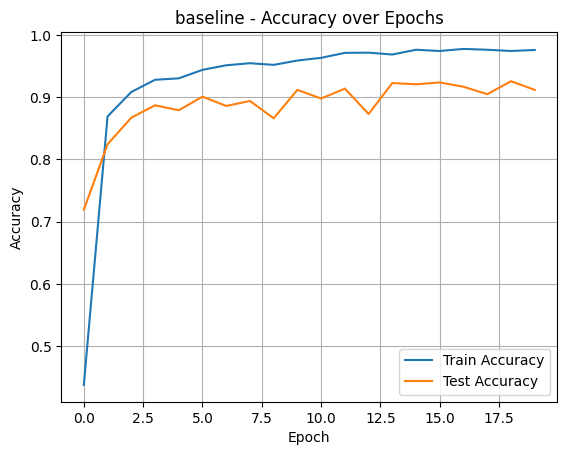

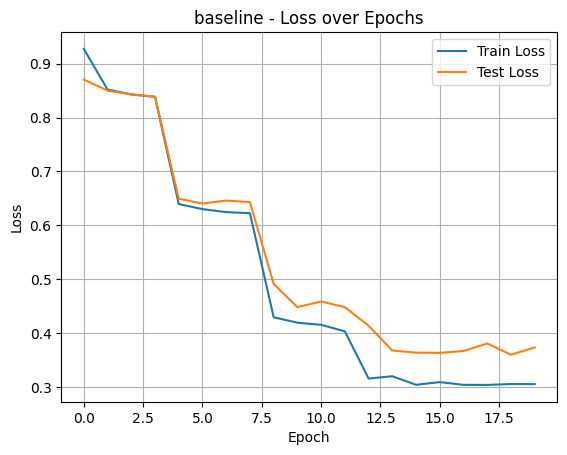

Plotting results for experiment: deep_net


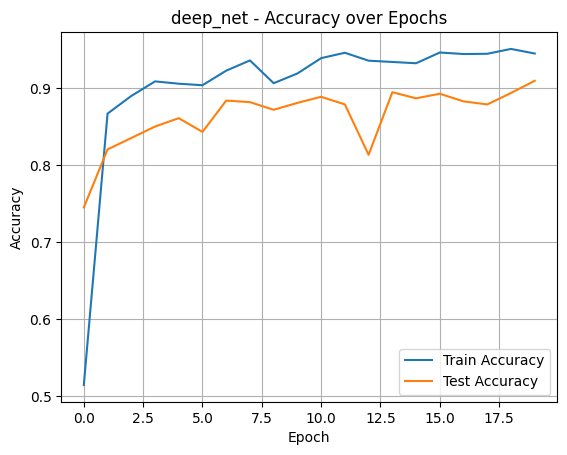

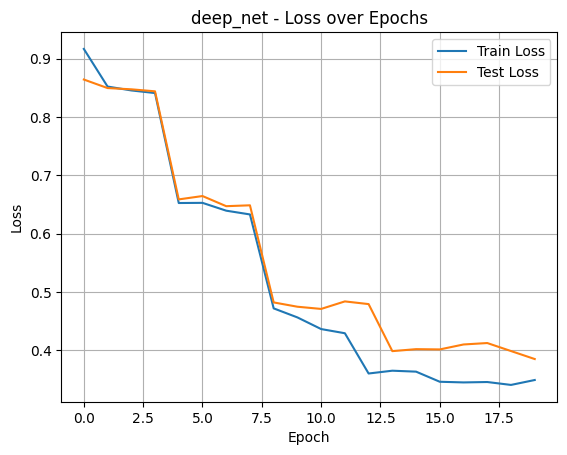

Plotting results for experiment: shallow_net


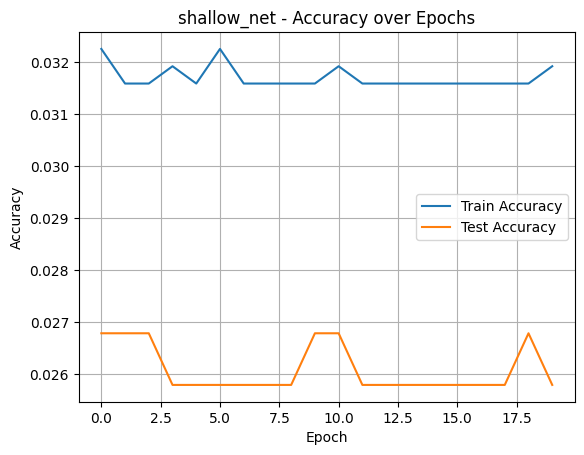

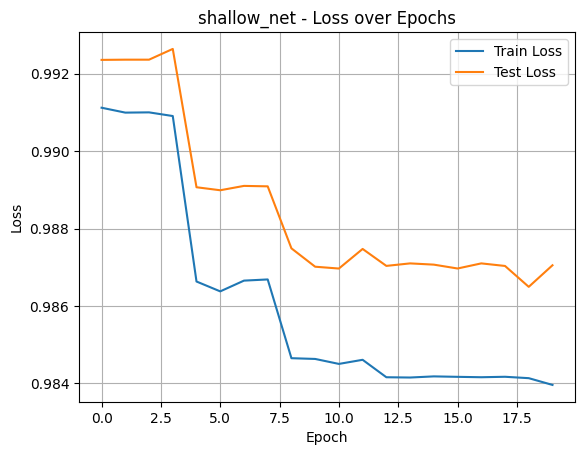

In [18]:
plot_all_experiments(results)


## Observations


For the baseline model:
- The model has a single hidden layer with 84 neurons, a learning rate of 0.001. Startiing from epoch cca 13, it seems like the model can't learn more information, as the accuracy and loss are not changing significantly, being around 90-95% and 0.3 respectively. We could also decrease the number of epochs to be cca 15, but for future tasks we will add more symbolic knowledge, thus it will be better to have a slightly higher number of epochs. Considering that this is a simple tasks, but has some symbolic knowledge, we can say that this is a good performance ( also considering that the MLP default layer_sizes = (84, )).

For the deep_net model:
- The model has two hidden layers with 128 and 64 neurons, a learning rate of 0.001. The model starts with a higher accuracy than the baseline, but it seems to overfit the training data, as the loss is slightly higher than the baseline. The accuracy is around 95% for both training and test data.

For the shallow_net model:
- The model has a single hidden layer with 32 neurons, a learning rate of 0.005. The model has an accuracy of around 3% for both training and test data, making it an unfeasible model, espcially due to its high learning rate. The loss is also constantly around 0.95.


Thus, for the following experiments, we will use the baseline and the deep_net models, as they seem to be the most promising ones.

## Multi Digit Addition


## Data

Result label is 130


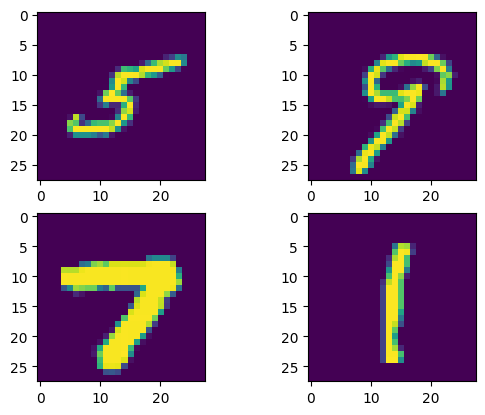

In [2]:
ds_train_multi_digit, ds_test_multi_digit = data.get_mnist_op_dataset(
        count_train=3000,
        count_test=1000,
        buffer_size=3000,
        batch_size=16,
        n_operands=4,
        op=lambda args: 10*args[0]+args[1]+10*args[2]+args[3])

# Visualize one example
x1, x2, y1, y2, z = next(ds_train_multi_digit.as_numpy_iterator())
plt.subplot(221)
plt.imshow(x1[0][:,:,0])
plt.subplot(222)
plt.imshow(x2[0][:,:,0])
plt.subplot(223)
plt.imshow(y1[0][:,:,0])
plt.subplot(224)
plt.imshow(y2[0][:,:,0])
print("Result label is %i" % z[0])

In [11]:
import commons as old_commons # here we use the orignal commons.py, because we don't want to run experiments wiith different learning rates ( as explained before)

# logits_model = baselines.SingleDigit(inputs_as_a_list=True)
# 
# @tf.function
# def digit_softmax_wrapper(x):
#     return tf.nn.softmax(logits_model(x))
# 
# class SoftmaxDigitModel(tf.keras.Model):
#     def __init__(self, base_model):
#         super().__init__()
#         self.base_model = base_model
# 
#     def call(self, x):
#         logits = self.base_model(x)
#         return tf.nn.softmax(logits)
# 
# # Create model with softmax built-in
# softmax_model = SoftmaxDigitModel(logits_model)
# Digit = ltn.Predicate.Lambda(lambda inputs: tf.gather(
#     softmax_model([inputs[0]]),  # x
#     indices=tf.cast(inputs[1], tf.int32),  # d
#     axis=1,
#     batch_dims=1
# ))
# ### Variables
d1 = ltn.Variable("digits1", range(10))
d2 = ltn.Variable("digits2", range(10))
d3 = ltn.Variable("digits3", range(10))
d4 = ltn.Variable("digits4", range(10))
### Operators
Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(),semantics="forall")
Exists = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMean(),semantics="exists")

In [12]:
# mask
add = ltn.Function.Lambda(lambda inputs: inputs[0]+inputs[1])
times = ltn.Function.Lambda(lambda inputs: inputs[0]*inputs[1])
ten = ltn.Constant(10, trainable=False)
equals = ltn.Predicate.Lambda(lambda inputs: inputs[0] == inputs[1])
two_digit_number = lambda inputs : add([times([ten,inputs[0]]), inputs[1] ])

# @tf.function
# def axioms(images_x1,images_x2,images_y1,images_y2,labels_z,p_schedule):
#     images_x1 = ltn.Variable("x1", images_x1)
#     images_x2 = ltn.Variable("x2", images_x2)
#     images_y1 = ltn.Variable("y1", images_y1)
#     images_y2 = ltn.Variable("y2", images_y2)
#     labels_z = ltn.Variable("z", labels_z)
#     axiom = Forall(
#             ltn.diag(images_x1,images_x2,images_y1,images_y2,labels_z),
#             Exists(
#                 (d1,d2,d3,d4),
#                 And(
#                     And(Digit([images_x1,d1]),Digit([images_x2,d2])),
#                     And(Digit([images_y1,d3]),Digit([images_y2,d4]))
#                 ),
#                 mask=equals([labels_z, add([ two_digit_number([d1,d2]), two_digit_number([d3,d4]) ]) ]),
#                 p=p_schedule
#             ),
#             p=2
#         )
#     sat = axiom.tensor
#     return sat

# x1, x2, y1, y2, z = next(ds_train_multi_digit.as_numpy_iterator())
# axioms(x1, x2, y1, y2, z, tf.constant(2.))

In [13]:
def create_axioms(Digit):
    @tf.function
    def axioms(images_x1, images_x2, images_y1, images_y2, labels_z, p_schedule):
        images_x1 = ltn.Variable("x1", images_x1)
        images_x2 = ltn.Variable("x2", images_x2)
        images_y1 = ltn.Variable("y1", images_y1)
        images_y2 = ltn.Variable("y2", images_y2)
        labels_z = ltn.Variable("z", labels_z)
        axiom = Forall(
            ltn.diag(images_x1, images_x2, images_y1, images_y2, labels_z),
            Exists(
                (d1, d2, d3, d4),
                And(
                    And(Digit([images_x1, d1]), Digit([images_x2, d2])),
                    And(Digit([images_y1, d3]), Digit([images_y2, d4]))
                ),
                mask=equals([labels_z, add([
                    two_digit_number([d1, d2]),
                    two_digit_number([d3, d4])
                ])]),
                p=p_schedule
            ),
            p=2
        )
        return axiom.tensor
    return axioms


In [14]:
# optimizer = tf.keras.optimizers.Adam(0.001)
metrics_dict = {
    'train_loss': tf.keras.metrics.Mean(name="train_loss"),
    'train_accuracy': tf.keras.metrics.Mean(name="train_accuracy"),
    'test_loss': tf.keras.metrics.Mean(name="test_loss"),
    'test_accuracy': tf.keras.metrics.Mean(name="test_accuracy")    
}
def create_train_test_steps(logits_model, optimizer, axioms):
    @tf.function
    def train_step(images_x1, images_x2, images_y1, images_y2, labels_z, **kwargs):
        with tf.GradientTape() as tape:
            loss = 1. - axioms(images_x1, images_x2, images_y1, images_y2, labels_z, **kwargs)
        gradients = tape.gradient(loss, logits_model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, logits_model.trainable_variables))
        metrics_dict['train_loss'](loss)

        predictions_x1 = tf.argmax(logits_model([images_x1]), axis=-1, output_type=tf.int32)
        predictions_x2 = tf.argmax(logits_model([images_x2]), axis=-1, output_type=tf.int32)
        predictions_y1 = tf.argmax(logits_model([images_y1]), axis=-1, output_type=tf.int32)
        predictions_y2 = tf.argmax(logits_model([images_y2]), axis=-1, output_type=tf.int32)
        predictions_z = 10*predictions_x1 + predictions_x2 + 10*predictions_y1 + predictions_y2
        match = tf.equal(predictions_z, tf.cast(labels_z, predictions_z.dtype))
        metrics_dict['train_accuracy'](tf.reduce_mean(tf.cast(match, tf.float32)))

    @tf.function
    def test_step(images_x1, images_x2, images_y1, images_y2, labels_z, **kwargs):
        loss = 1. - axioms(images_x1, images_x2, images_y1, images_y2, labels_z, **kwargs)
        metrics_dict['test_loss'](loss)

        predictions_x1 = tf.argmax(logits_model([images_x1]), axis=-1, output_type=tf.int32)
        predictions_x2 = tf.argmax(logits_model([images_x2]), axis=-1, output_type=tf.int32)
        predictions_y1 = tf.argmax(logits_model([images_y1]), axis=-1, output_type=tf.int32)
        predictions_y2 = tf.argmax(logits_model([images_y2]), axis=-1, output_type=tf.int32)
        predictions_z = 10*predictions_x1 + predictions_x2 + 10*predictions_y1 + predictions_y2
        match = tf.equal(predictions_z, tf.cast(labels_z, predictions_z.dtype))
        metrics_dict['test_accuracy'](tf.reduce_mean(tf.cast(match, tf.float32)))

    return train_step, test_step



In [15]:
from collections import defaultdict

def get_scheduled_parameters(schedules = [1., 2., 4., 6.]):
    scheduled_parameters = defaultdict(lambda: {})
    # for idx, param in enumerate(schedules):
    # if idx >=2:
    #     for epoch in range(idx * 4, (idx + 1) * 4):
    #         scheduled_parameters[epoch] = {"p_schedule":tf.constant(param)}
    # return scheduled_parameters
    for epoch in range(0,4):
        scheduled_parameters[epoch] = {"p_schedule":tf.constant(schedules[0])}
    for epoch in range(4,8):
        scheduled_parameters[epoch] = {"p_schedule":tf.constant(schedules[1])}
    for epoch in range(8,12):
        scheduled_parameters[epoch] = {"p_schedule":tf.constant(schedules[2])}
    for epoch in range(12,20):
        scheduled_parameters[epoch] = {"p_schedule":tf.constant(schedules[3])}
    if len(schedules) > 4:
        for epoch in range(20,30):
            scheduled_parameters[epoch] = {"p_schedule":tf.constant(schedules[4])}
    return scheduled_parameters


In [16]:
def run_experiment_multi_digit(name, scheduled_parameters= [1., 2., 4., 6.], max_epochs=20, train_step = None, test_step= None):
    print(f"Running experiment: {name}")
    scheduled_parameters = get_scheduled_parameters(scheduled_parameters)
    history = old_commons.train(
        epochs=max_epochs,
        metrics_dict=metrics_dict,
        ds_train=ds_train_multi_digit,
        ds_test=ds_test_multi_digit,
        train_step=train_step_multi_digits,
        test_step=test_step_multi_digits,
        scheduled_parameters=scheduled_parameters
    )
    return name, history


In [18]:
experiments = [
    {"name": "baseline_multi_digit", "scheduled_params": [1., 2., 4., 6.], "max_epochs": 20},
    {"name": "stricter_faster_multi_digit", "scheduled_params": [1., 3., 6., 8.], "max_epochs": 20},
    {"name": "stricter_looser_multi_digit", "scheduled_params": [1., 2., 4., 6., 7.], "max_epochs": 30},
]
results = []

for config in experiments:
    for metric in metrics_dict.values():
        metric.reset_state()
    Digit, logits_model = create_Digit_model()
    optimizer = tf.keras.optimizers.Adam(0.001)

    # softmax_model = SoftmaxDigitModel(logits_model)
    # Digit = ltn.Predicate.Lambda(lambda inputs: tf.gather(
    #     softmax_model([inputs[0]]),
    #     indices=tf.cast(inputs[1], tf.int32),
    #     axis=1,
    #     batch_dims=1
    # ))
    
    axioms = create_axioms(Digit)
    train_step_multi_digits, test_step_multi_digits = create_train_test_steps(logits_model, optimizer, axioms)



    results.append(run_experiment_multi_digit(
        name=config["name"],
        scheduled_parameters=config["scheduled_params"],
        max_epochs=config["max_epochs"],
        train_step=train_step_multi_digits,
        test_step=test_step_multi_digits
    ))



Running experiment: baseline_multi_digit
Epoch 0, train_loss: 0.9995, train_accuracy: 0.0199, test_loss: 0.9991, test_accuracy: 0.0506
Epoch 1, train_loss: 0.9983, train_accuracy: 0.0888, test_loss: 0.9986, test_accuracy: 0.0565
Epoch 2, train_loss: 0.9972, train_accuracy: 0.1406, test_loss: 0.9971, test_accuracy: 0.1310
Epoch 3, train_loss: 0.9961, train_accuracy: 0.1941, test_loss: 0.9965, test_accuracy: 0.1776
Epoch 4, train_loss: 0.9533, train_accuracy: 0.3939, test_loss: 0.9376, test_accuracy: 0.4772
Epoch 5, train_loss: 0.9147, train_accuracy: 0.6782, test_loss: 0.9010, test_accuracy: 0.7599
Epoch 6, train_loss: 0.8896, train_accuracy: 0.8674, test_loss: 0.8968, test_accuracy: 0.7897
Epoch 7, train_loss: 0.8857, train_accuracy: 0.8903, test_loss: 0.8946, test_accuracy: 0.8125
Epoch 8, train_loss: 0.7085, train_accuracy: 0.8730, test_loss: 0.7297, test_accuracy: 0.7917
Epoch 9, train_loss: 0.6899, train_accuracy: 0.9036, test_loss: 0.7070, test_accuracy: 0.8433
Epoch 10, train_los

In [21]:
def plot_all_experiments(results):
    for name, history in results:
        print(f"Plotting results for experiment: {name}")
        
        # Plot Accuracy
        plt.figure()
        plt.plot(range(len(history['train_accuracy'])), history['train_accuracy'], label='Train Accuracy')
        plt.plot(range(len(history['test_accuracy'])), history['test_accuracy'], label='Test Accuracy')
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title(f"{name} - Accuracy over Epochs")
        plt.grid(True)
        plt.legend()
        plt.show()

        # Plot Loss
        plt.figure()
        plt.plot(range(len(history['train_loss'])), history['train_loss'], label='Train Loss')
        plt.plot(range(len(history['test_loss'])), history['test_loss'], label='Test Loss')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"{name} - Loss over Epochs")
        plt.grid(True)
        plt.legend()
        plt.show()


Plotting results for experiment: baseline_multi_digit


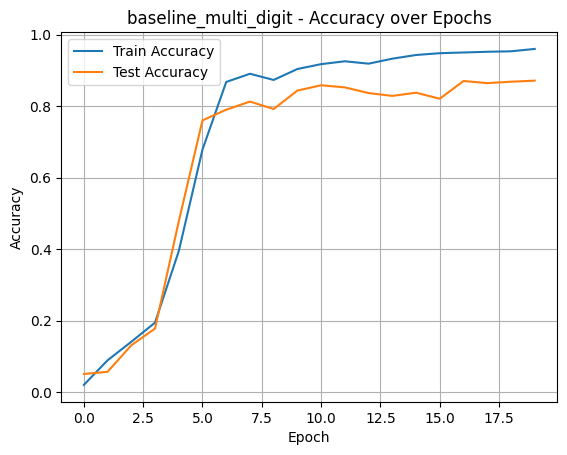

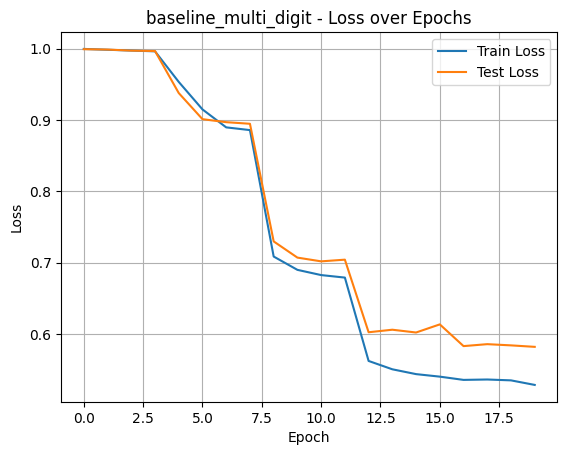

Plotting results for experiment: stricter_faster_multi_digit


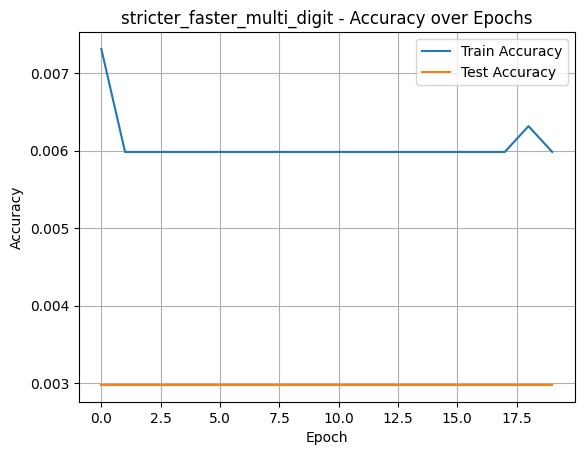

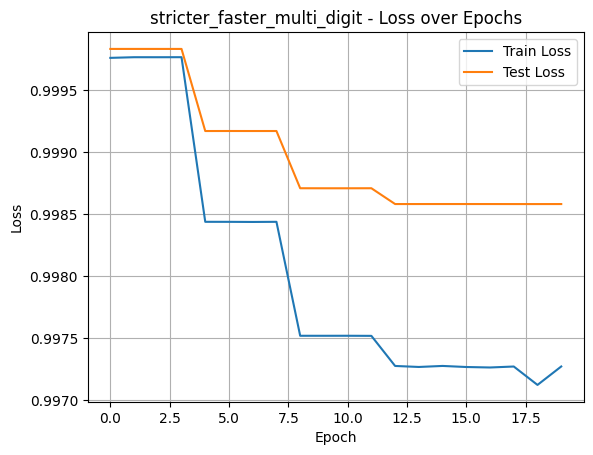

Plotting results for experiment: stricter_looser_multi_digit


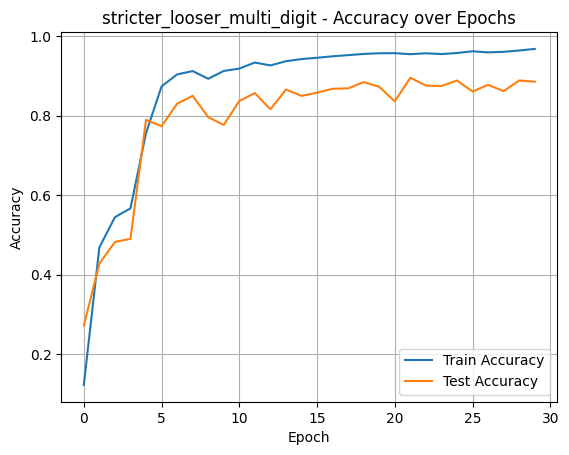

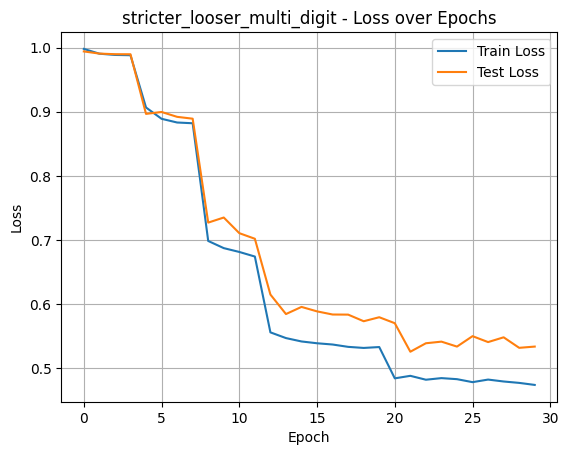

In [22]:
plot_all_experiments(results)

In [24]:
# redo second experiment since there probably was an issue with it before
results_stricter_faster_multi_digit = []
for metric in metrics_dict.values():
        metric.reset_state()
Digit, logits_model = create_Digit_model()
optimizer = tf.keras.optimizers.Adam(0.001)
axioms = create_axioms(Digit)
train_step_multi_digits, test_step_multi_digits = create_train_test_steps(logits_model, optimizer, axioms)
results_stricter_faster_multi_digit.append(
run_experiment_multi_digit(
    name="stricter_faster_multi_digit",
    scheduled_parameters=[1., 3., 6., 8.],
    max_epochs=20,
    train_step=train_step_multi_digits,
    test_step=test_step_multi_digits
))


Running experiment: stricter_faster_multi_digit
Epoch 0, train_loss: 0.9996, train_accuracy: 0.0173, test_loss: 0.9997, test_accuracy: 0.0109
Epoch 1, train_loss: 0.9996, train_accuracy: 0.0166, test_loss: 0.9997, test_accuracy: 0.0099
Epoch 2, train_loss: 0.9995, train_accuracy: 0.0206, test_loss: 0.9997, test_accuracy: 0.0129
Epoch 3, train_loss: 0.9993, train_accuracy: 0.0312, test_loss: 0.9998, test_accuracy: 0.0050
Epoch 4, train_loss: 0.9949, train_accuracy: 0.0259, test_loss: 0.9952, test_accuracy: 0.0208
Epoch 5, train_loss: 0.9962, train_accuracy: 0.0213, test_loss: 0.9971, test_accuracy: 0.0139
Epoch 6, train_loss: 0.9986, train_accuracy: 0.0066, test_loss: 0.9971, test_accuracy: 0.0139
Epoch 7, train_loss: 0.9986, train_accuracy: 0.0066, test_loss: 0.9971, test_accuracy: 0.0139
Epoch 8, train_loss: 0.9974, train_accuracy: 0.0066, test_loss: 0.9948, test_accuracy: 0.0139
Epoch 9, train_loss: 0.9975, train_accuracy: 0.0066, test_loss: 0.9948, test_accuracy: 0.0139
Epoch 10, tr

In [ ]:
plot_results(results_stricter_faster_multi_digit)

## Observations

## Single Digit Addition with More Symbolic Knowledge